# Chest X-Ray Classification using Convolutional Neural Networks (CNNs)

The objective of this task is to design, implement, and evaluate two convolutional neural networks (CNNs) for the classification of chest X-ray images: normal vs. effusion.

Prodecure summary:
1. Data import and exploration
2. Image preprocessing
3. Data splitting
4. Model development
5. Evaluation and comparison
6. Conclusion

## **0. Library import**

We import the necessary libraries and modules, and activate the GPU by selecting 'Change runtime type' → 'GPU'.

In [47]:
# For data manipulation:
import pandas as pd
import numpy as np

# OS functions
import zipfile
import os

# For data visualization
import matplotlib.pyplot as plt

# Image processing
import cv2

# Train/test split
from sklearn.model_selection import train_test_split

# Tensorflow/keras to develop the CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# To evaluate performance
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Reproducible results
import random
seed = 123
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## **1. Data import, dataset preparation and exploration of images**

### 1.1. Data import

In the Google Drive folder, we've uploaded the zip files: *normal.zip* and *effusion.zip*. Now we open, unzip, and load these two files.

In [48]:
# Google Colab asks for access
# This step is specific to Google Colab, to access files stored in Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [49]:
# Extraction of the folder containing the normal chest X-rays
zip_normal = zipfile.ZipFile("/content/drive/My Drive/Portfolio/data/normal.zip", 'r')
zip_normal.extractall("data/normal")
zip_normal.close()

# Extraction of the folder containing the effusion chest X-rays
zip_derrame = zipfile.ZipFile("/content/drive/My Drive/Portfolio/data/effusion.zip", 'r')
zip_derrame.extractall("data/effusion")
zip_derrame.close()

### 1.2. Preparation of datasets

To **prepare the datasets**, we create a data frame where each image is associated with its label: normal or effusion. For now, this dataframe will contain the path to each image.

In [50]:
# The path to the unzipped folders is as follows
carpeta_normal = 'data/normal/normal'
carpeta_derrame = 'data/effusion/effusion'

lista_normal_derrame = []

# For each normal image, we assign the image name with its label: 'normal'

imagenes_normales_lista = os.listdir(carpeta_normal)  # We get the list of normal chest X-ray images in this folder!!

for nombre_imagen in imagenes_normales_lista:
  path = os.path.join(carpeta_normal, nombre_imagen)  # We join the image name with the folder path to get the full image 'path'!
  lista_normal_derrame.append({'path': path, 'label': 'normal'})  # Then, we create a second column for the dataframe: its label

# For each effusion image, we assign the image name with its label: 'effusion'

imagenes_derrame_lista = os.listdir(carpeta_derrame)

for nombre_imagen in imagenes_derrame_lista:
  path = os.path.join(carpeta_derrame, nombre_imagen)
  lista_normal_derrame.append({'path': path, 'label': 'effusion'})

df_imagenes = pd.DataFrame(lista_normal_derrame)  # We obtain the dataframe with the normal and effusion images, along with their label indicating whether they are normal or not

print(df_imagenes)

                                path     label
0        data/normal/normal/n194.png    normal
1        data/normal/normal/n302.png    normal
2        data/normal/normal/n150.png    normal
3        data/normal/normal/n277.png    normal
4          data/normal/normal/n8.png    normal
..                               ...       ...
695  data/effusion/effusion/e188.png  effusion
696  data/effusion/effusion/e293.png  effusion
697   data/effusion/effusion/e69.png  effusion
698  data/effusion/effusion/e325.png  effusion
699  data/effusion/effusion/e266.png  effusion

[700 rows x 2 columns]


The created dataframe contains two columns: the **path**, which stores the location of each image; and its **label**, which indicates whether the image is a normal or an effusion chest x-ray.

We can also confirm that there are 350 chest X-rays of each type:

In [51]:
print(df_imagenes['label'].value_counts())

label
normal      350
effusion    350
Name: count, dtype: int64


### 1.3. Image exploration

Now that we have the path to all images, we can access to each all of them. We use the **cv2** package to preprocess and visualize the images.

Let's take a look at some of the images in this dataset:

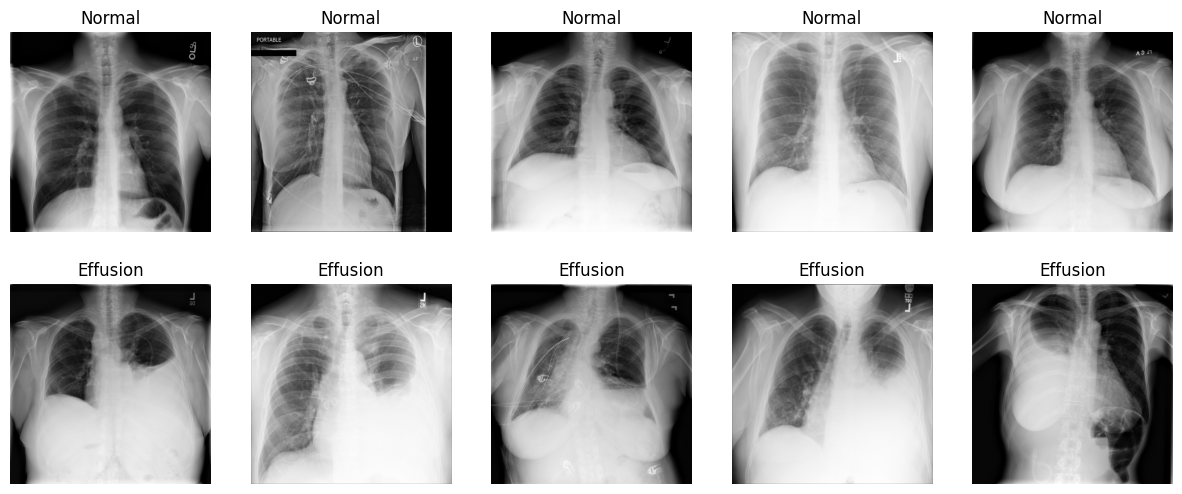

In [52]:
# Let's display random images from each class label. We’ll set a seed for reproducibility
np.random.seed(123)

# Get the indices of the normal images and the effusion images
indice_normal = df_imagenes[df_imagenes['label'] == 'normal'].index
indice_derrame = df_imagenes[df_imagenes['label'] == 'effusion'].index

# Now we’ll randomly select 5 images from each class using their indices
indice_aleatorio_normal = np.random.choice(indice_normal, 5)
indice_aleatorio_derrame = np.random.choice(indice_derrame, 5)

# Now we can display the images:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # We'll create a figure with 2 rows and 5 columns

# Display the normal images
for i, indice in enumerate(indice_aleatorio_normal):   # For each index in the indice_aleatorio vector
    imagen_path = df_imagenes.loc[indice, 'path']      # Get the path so we can read the image
    imagen = cv2.imread(imagen_path, cv2.IMREAD_GRAYSCALE)   # Reads the image in grayscale at the given index
    axs[0, i].imshow(imagen, cmap='gray')
    axs[0, i].set_title("Normal")  # We’ll also add a title to indicate that this is a normal X-ray
    axs[0, i].axis('off')   # Hide axes

# Display the effusion images
for i, indice in enumerate(indice_aleatorio_derrame):
    imagen_path = df_imagenes.loc[indice, 'path']
    imagen = cv2.imread(imagen_path, cv2.IMREAD_GRAYSCALE)
    axs[1, i].imshow(imagen, cmap='gray')
    axs[1, i].set_title("Effusion")
    axs[1, i].axis('off')

## **2.	Image preprocessing**

### 2.1. Image reshaping

Let's have a look at the images sizes:

In [53]:
imagen1 = cv2.imread(df_imagenes.iloc[0]['path'])
imagen2 = cv2.imread(df_imagenes.iloc[168]['path'])
imagen3 = cv2.imread(df_imagenes.iloc[456]['path'])

print(imagen1.shape)
print(imagen2.shape)
print(imagen3.shape)

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


The original images have a size of 512×512 pixels and three color channels (RGB). They are reshaped to **64×64** pixels and only **one channel**.

The pixel values are also normalized using  **min-max scaling.**

We will also be using NumPy arrays, since CNNs work with them as input.

In [54]:
# Lists to store images and labels
x = []  # for processed images
y = []  # for labels (normal/effusion)

# We use a loop to get through each row of the DataFrame
for i, fila in df_imagenes.iterrows():
    path = fila['path']        # image path
    label = fila['label']      # label (normal/effusion)

    # Load the images in grayscale
    imagen_gris = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Reshape and resize to 64x64
    imagen_tamaño = cv2.resize(imagen_gris, (64, 64))

    # TWe keep only one dimension (64, 64, 1)
    imagen_final = np.expand_dims(imagen_tamaño, axis=-1)

    # We save each image and its label in binary format
    x.append(imagen_final)
    y.append(1 if fila['label'] == 'effusion' else 0)  # So, 1 = effusion, 0 = normal

x = np.array(x)  # array with the images
y = np.array(y)  # array with the binary labels


Let's now check the images' shape:

In [55]:
print(x[0].shape)
print(x[168].shape)
print(x[456].shape)

(64, 64, 1)
(64, 64, 1)
(64, 64, 1)


### 2.2. Image normalization

Even though the images are already preprocessed and in grayscale, their pixel values are still in the range [0, 255].

In [56]:
v_min = np.min(x)
v_max = np.max(x)
print("Minimum and maximum values before normalization: {} y {}.".format(v_min, v_max))

# Normalización. Fuente 8
x_normal = (x - v_min) / (v_max - v_min)
print("Minimum and maximum values after normalization: {} y {}.".format(np.min(x_normal), np.max(x_normal)))


Minimum and maximum values before normalization: 0 y 255.
Minimum and maximum values after normalization: 0.0 y 1.0.


## **3. Data splitting**

Dataset splitting into 600 images for training and 100 for testing, while balancing both classes.

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x_normal, y, test_size=100, shuffle=True, random_state=0, stratify=y)

print("Training set size:", len(x_train))
print("Test set size:", len(x_test))

print("\nNumber of classes in the training set:")
print(pd.Series(y_train).value_counts())
print("\nNumber of classes in the test set:")
print(pd.Series(y_test).value_counts())

print(f"\nx_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

Training set size: 600
Test set size: 100

Number of classes in the training set:
0    300
1    300
Name: count, dtype: int64

Number of classes in the test set:
1    50
0    50
Name: count, dtype: int64

x_train: (600, 64, 64, 1)
y_train: (600,)
x_test: (100, 64, 64, 1)
y_test: (100,)


The training dataset contains 300 normal images (0) and 300 effusion images (1). The test dataset consists of 50 normal images (0) and 50 effusion images (1). All have a size of 64×64 and one channel.

## **4. Model development**

The conditions for the model include:

- Number of convolutional layers =< 6

- Pooling layers must be included

- In the lower part of the network, the fully connected layers should have 128 and 32 nodes

- Output layer with 'sigmoid' activation

- Trainable parameters must be at least 60,000

### 4.1. First model

In [58]:
input_forma = (64, 64, 1)

model1 = Sequential()  # The sequential model allows stacking different layers. These are the following

model1.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=input_forma, activation='relu', padding='same'))
# first convolutional layer, indicating the number of filters used, the filter size, and the expected input image size (only in the first layer)
model1.add(BatchNormalization())
model1.add(Conv2D(filters=16, kernel_size= (3,3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Flatten())  # flatten layer to transition to dense layers
model1.add(Dense(128, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))  # This is our output layer. We use sigmoid activation because the classification is binary

model1.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069,617 (4.08 MB)

 Trainable params: 1,069,425 (4.08 MB)

 Non-trainable params: 192 (768.00 B)

### 4.2. Second model

In [59]:
input_forma = (64, 64, 1)

model2 = Sequential()

model2.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_forma))
model2.add(BatchNormalization())
model2.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2)))
model2.add(Dropout(0.5)) # dropout 0.5!!

model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2)))
model2.add(Dropout(0.5))

# New! We introduce a third block
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2)))
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            3

 Total params: 601,265 (2.29 MB)

 Trainable params: 600,817 (2.29 MB)

 Non-trainable params: 448 (1.75 KB)

Once we have defined the model, it is necessary to **compile** it. We will also be using the **Adam** optimizer.

We also use the **binary_crossentropy** loss function since we are performing binary classification (normal vs effusion).

In [60]:
model1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

Now we can start training the model. We will make the model see each image 30 times (epochs). We also set the batch size to 32. Finally, we use the test set to validate the model's performance after each epoch.

In [61]:
history1 = model1.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 0.6725 - loss: 1.1765 - val_accuracy: 0.5000 - val_loss: 0.7931
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8478 - loss: 0.3754 - val_accuracy: 0.5000 - val_loss: 1.1404
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8894 - loss: 0.2447 - val_accuracy: 0.5000 - val_loss: 1.5627
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9422 - loss: 0.1544 - val_accuracy: 0.5000 - val_loss: 1.9232
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9679 - loss: 0.1047 - val_accuracy: 0.5000 - val_loss: 2.2942
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9444 - loss: 0.1444 - val_accuracy: 0.5000 - val_loss: 2.4491
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8646 - loss: 0.3062 - val_accuracy: 0.5000 - val_loss: 1.8771
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8887 - loss: 0.2531 - val_accuracy: 0.5000 -

In [62]:
model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [63]:
history2 = model2.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 458ms/step - accuracy: 0.5173 - loss: 1.2147 - val_accuracy: 0.5000 - val_loss: 0.7072
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6771 - loss: 0.6040 - val_accuracy: 0.5000 - val_loss: 0.7198
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7396 - loss: 0.5096 - val_accuracy: 0.5000 - val_loss: 0.8120
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7864 - loss: 0.4831 - val_accuracy: 0.5000 - val_loss: 0.9506
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8010 - loss: 0.4378 - val_accuracy: 0.5000 - val_loss: 0.9228
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7863 - loss: 0.4462 - val_accuracy: 0.5000 - val_loss: 0.7639
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8161 - loss: 0.4161 - val_accuracy: 0.5000 - val_loss: 0.9092
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8286 - loss: 0.3881 - val_accuracy: 0.5000 -

## **5. Evaluation and comparison**



Despite fixing random seeds at the beginning of the script, minor variations in ROC curve and confusion matrix results were observed. This is due to the stochastic nature of CNN training, especially when using dropout and GPU computation.

### 5.1. Loss and accuracy

Loss and accuracy values for the training and validation data of the first and second model.

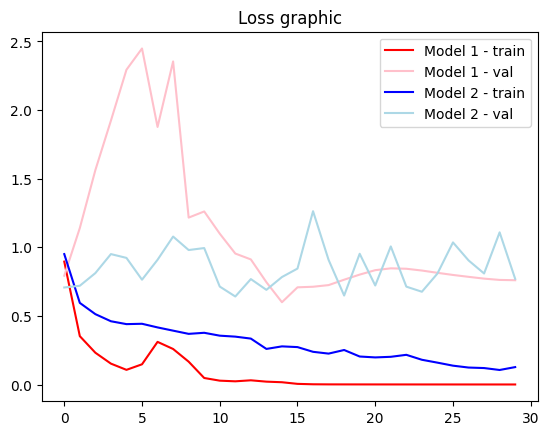

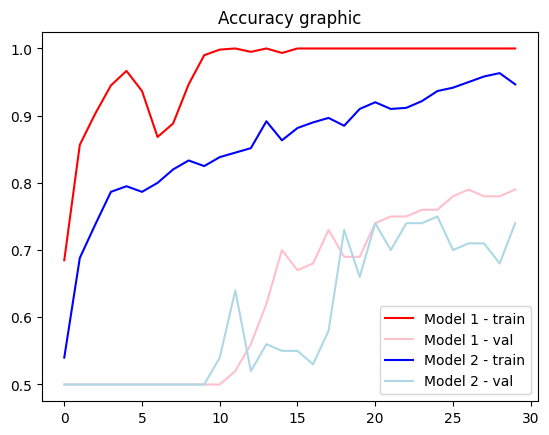

In [68]:
# Loss values are plotted for train and test data
plt.plot(history1.history['loss'], label='Model 1 - train', color = 'red')
plt.plot(history1.history['val_loss'], label='Model 1 - val', color = 'pink')
plt.plot(history2.history['loss'], label='Model 2 - train', color = 'blue')
plt.plot(history2.history['val_loss'], label='Model 2 - val', color = 'lightblue')
plt.title('Loss graphic')
plt.legend()
plt.show()

# Accuracy values are plotted for train and test data
plt.plot(history1.history['accuracy'], label='Model 1 - train', color = 'red')
plt.plot(history1.history['val_accuracy'], label='Model 1 - val', color = 'pink')
plt.plot(history2.history['accuracy'], label='Model 2 - train', color = 'blue')
plt.plot(history2.history['val_accuracy'], label='Model 2 - val', color = 'lightblue')
plt.title('Accuracy graphic')
plt.legend()
plt.show()

**Model 1**

Training loss and accuracy improve over time, although a small drop in accuracy is observed around epoch 6. Validation loss and accuracy values struggle at the begging but recover around epoch 10.

**Model 2**

Training loss and accuracy also improve over time, but the progress is more moderate than Model 1 values. Test loss and accuracy values show ups and downs, suggesting that the model struggles to generalize consistently, despite achieving good results.

### 5.2. ROC curve evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


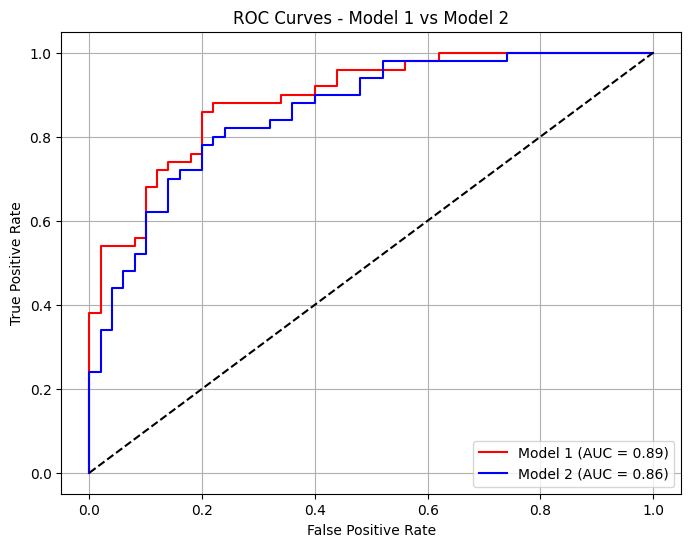

In [69]:
# Predictions
y_prediction_mod1 = model1.predict(x_test)
y_prediction_mod2 = model2.predict(x_test)

# Model 1
fpr1, tpr1, _ = roc_curve(y_test, y_prediction_mod1)
roc_auc1 = auc(fpr1, tpr1)

# Model 2
fpr2, tpr2, _ = roc_curve(y_test, y_prediction_mod2)
roc_auc2 = auc(fpr2, tpr2)

# Let's represent the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color = 'red', label=f'Model 1 (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color = 'blue', label=f'Model 2 (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model 1 vs Model 2')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The previous results on loss and accuracy are consistent with the ROC curves. Model 1 achieves a higher AUC (0.89) compared to Model 2 (0.86),  with a curve closer to the top left corner. This indicates superior discriminative ability.

### 5.3. Classification metrics

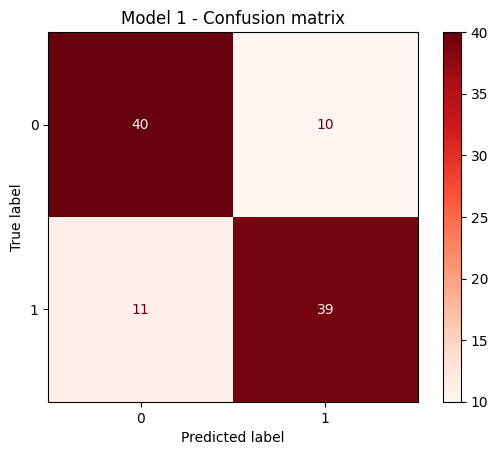

Classification Report - Model 1
              precision    recall  f1-score   support

           0       0.78      0.80      0.79        50
           1       0.80      0.78      0.79        50

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100



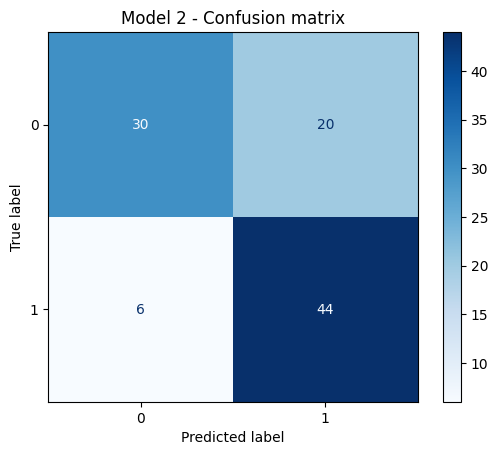

Classification Report - Model 2
              precision    recall  f1-score   support

           0       0.83      0.60      0.70        50
           1       0.69      0.88      0.77        50

    accuracy                           0.74       100
   macro avg       0.76      0.74      0.73       100
weighted avg       0.76      0.74      0.73       100



In [70]:
#Convert predictions to binary values
y_pred_mod1_binary = (y_prediction_mod1 > 0.5).astype(int)
y_pred_mod2_binary = (y_prediction_mod2 > 0.5).astype(int)

#Calculate the confusion matrix
confusion_matrix_mod1 = confusion_matrix(y_test, y_pred_mod1_binary)
confusion_matrix_mod2 = confusion_matrix(y_test, y_pred_mod2_binary)

# Confusion matrix for model 1
cm_display_1 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_mod1, display_labels=[0, 1])
cm_display_1.plot(cmap = 'Reds')
plt.title("Model 1 - Confusion matrix")
plt.show()

# Classification report for model 1
print("Classification Report - Model 1")
print(classification_report(y_test, y_pred_mod1_binary))

# Confusion matrix for model 2
cm_display_2 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_mod2, display_labels=[0, 1])
cm_display_2.plot(cmap = 'Blues')
plt.title("Model 2 - Confusion matrix")
plt.show()

# Classification report for model 2
print("Classification Report - Model 2")
print(classification_report(y_test, y_pred_mod2_binary))


The confusion matrixes show Model 1 has a higher precision (0.79) compared to Model 2 (0.76).
However, Model 2 obtains fewer false negatives than to Model 1.

## **6. Conclusion**

Model 1 outperforms Model 2 across multiple metrics. It achieves lower loss, higher accuracy, a better AUC and higher precision, although Model 2 detects slightly fewer false negatives.

Overall, Model 1 demonstrates superior ability to discriminate between normal and pathological radiographs.